In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier



Вам предоставлен набор данных, который содержит информацию о клиентах банка:

- client_id - ID клиента (неотрицательное целое число)

- Age - возраст (вещественный)

- Income - месячный доход (вещественный)

- BalanceToCreditLimit - отношение баланса на кредитной карте к лимту по кредиту (вещественный)

- DIR - Debt-to-income Ratio (вещественный)

- NumLoans - число заемов и кредитных линий

- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)

- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)

- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)

- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)

- Delinquent90 - Таргет, были ли просрочки выплат по кредиту более 90 дней (бинарный)


In [6]:
df = pd.read_csv('credit_scoring.csv')
display(df.head())
display(df.info())
display(df.describe())

,client_id,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
0,0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227,0
3,3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930,0
4,4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              75000 non-null  int64  
 1   DIR                    75000 non-null  float64
 2   Age                    75000 non-null  float64
 3   NumLoans               75000 non-null  int64  
 4   NumRealEstateLoans     75000 non-null  int64  
 5   NumDependents          73084 non-null  float64
 6   Num30-59Delinquencies  75000 non-null  int64  
 7   Num60-89Delinquencies  75000 non-null  int64  
 8   Income                 60153 non-null  float64
 9   BalanceToCreditLimit   75000 non-null  float64
 10  Delinquent90           75000 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 6.3 MB


None

,client_id,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
count,75000.000000,75000.000000,75000.000000,75000.00000,75000.000000,73084.000000,75000.000000,75000.000000,6.015300e+04,75000.000000,75000.000000
mean,37499.500000,353.260293,52.595605,8.44976,1.016693,0.755966,0.428320,0.248000,6.740059e+03,6.276196,0.066840
std,21650.779432,2117.237432,14.869729,5.15644,1.124019,1.108119,4.276439,4.239486,1.422875e+04,267.743321,0.249746
min,0.000000,0.000000,21.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,18749.750000,0.176022,41.300000,5.00000,0.000000,0.000000,0.000000,0.000000,3.421354e+03,0.029703,0.000000
50%,37499.500000,0.366848,52.200000,8.00000,1.000000,0.000000,0.000000,0.000000,5.424552e+03,0.153720,0.000000
75%,56249.250000,0.862650,63.100000,11.00000,2.000000,1.000000,0.000000,0.000000,8.291518e+03,0.560638,0.000000
max,74999.000000,332600.272820,109.800000,56.00000,32.000000,20.000000,98.000000,98.000000,1.805573e+06,50873.874533,1.000000


# Пропущенные значения

In [4]:
df.isnull().sum()   

client_id                    0
DIR                          0
Age                          0
NumLoans                     0
NumRealEstateLoans           0
NumDependents             1916
Num30-59Delinquencies        0
Num60-89Delinquencies        0
Income                   14847
BalanceToCreditLimit         0
Delinquent90                 0
dtype: int64

In [7]:
df = df.fillna(df.mean())

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              75000 non-null  int64  
 1   DIR                    75000 non-null  float64
 2   Age                    75000 non-null  float64
 3   NumLoans               75000 non-null  int64  
 4   NumRealEstateLoans     75000 non-null  int64  
 5   NumDependents          75000 non-null  float64
 6   Num30-59Delinquencies  75000 non-null  int64  
 7   Num60-89Delinquencies  75000 non-null  int64  
 8   Income                 75000 non-null  float64
 9   BalanceToCreditLimit   75000 non-null  float64
 10  Delinquent90           75000 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 6.3 MB


# Дубликаты

In [6]:
print(f"Количество дубликатов: {df.duplicated().sum()}")
df[df.duplicated(keep=False)]

Количество дубликатов: 0


,client_id,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90


# Гистограммы признаков

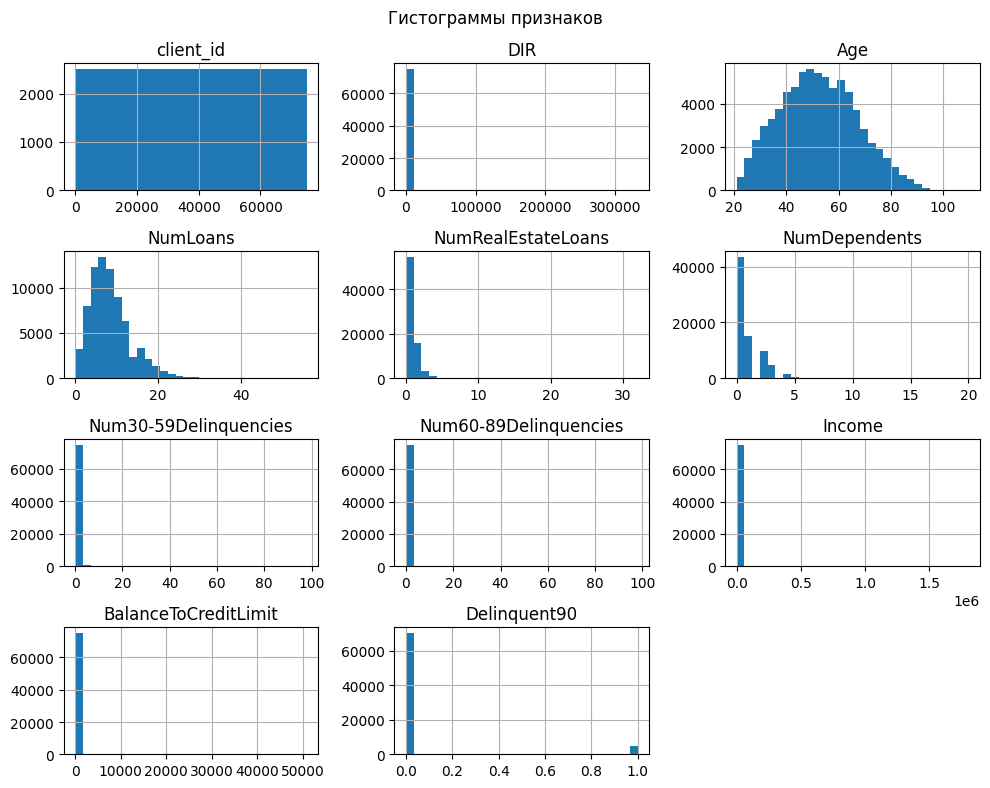

In [7]:
df.hist(figsize=(10, 8), bins=30)
plt.suptitle("Гистограммы признаков")
plt.tight_layout()
plt.show()

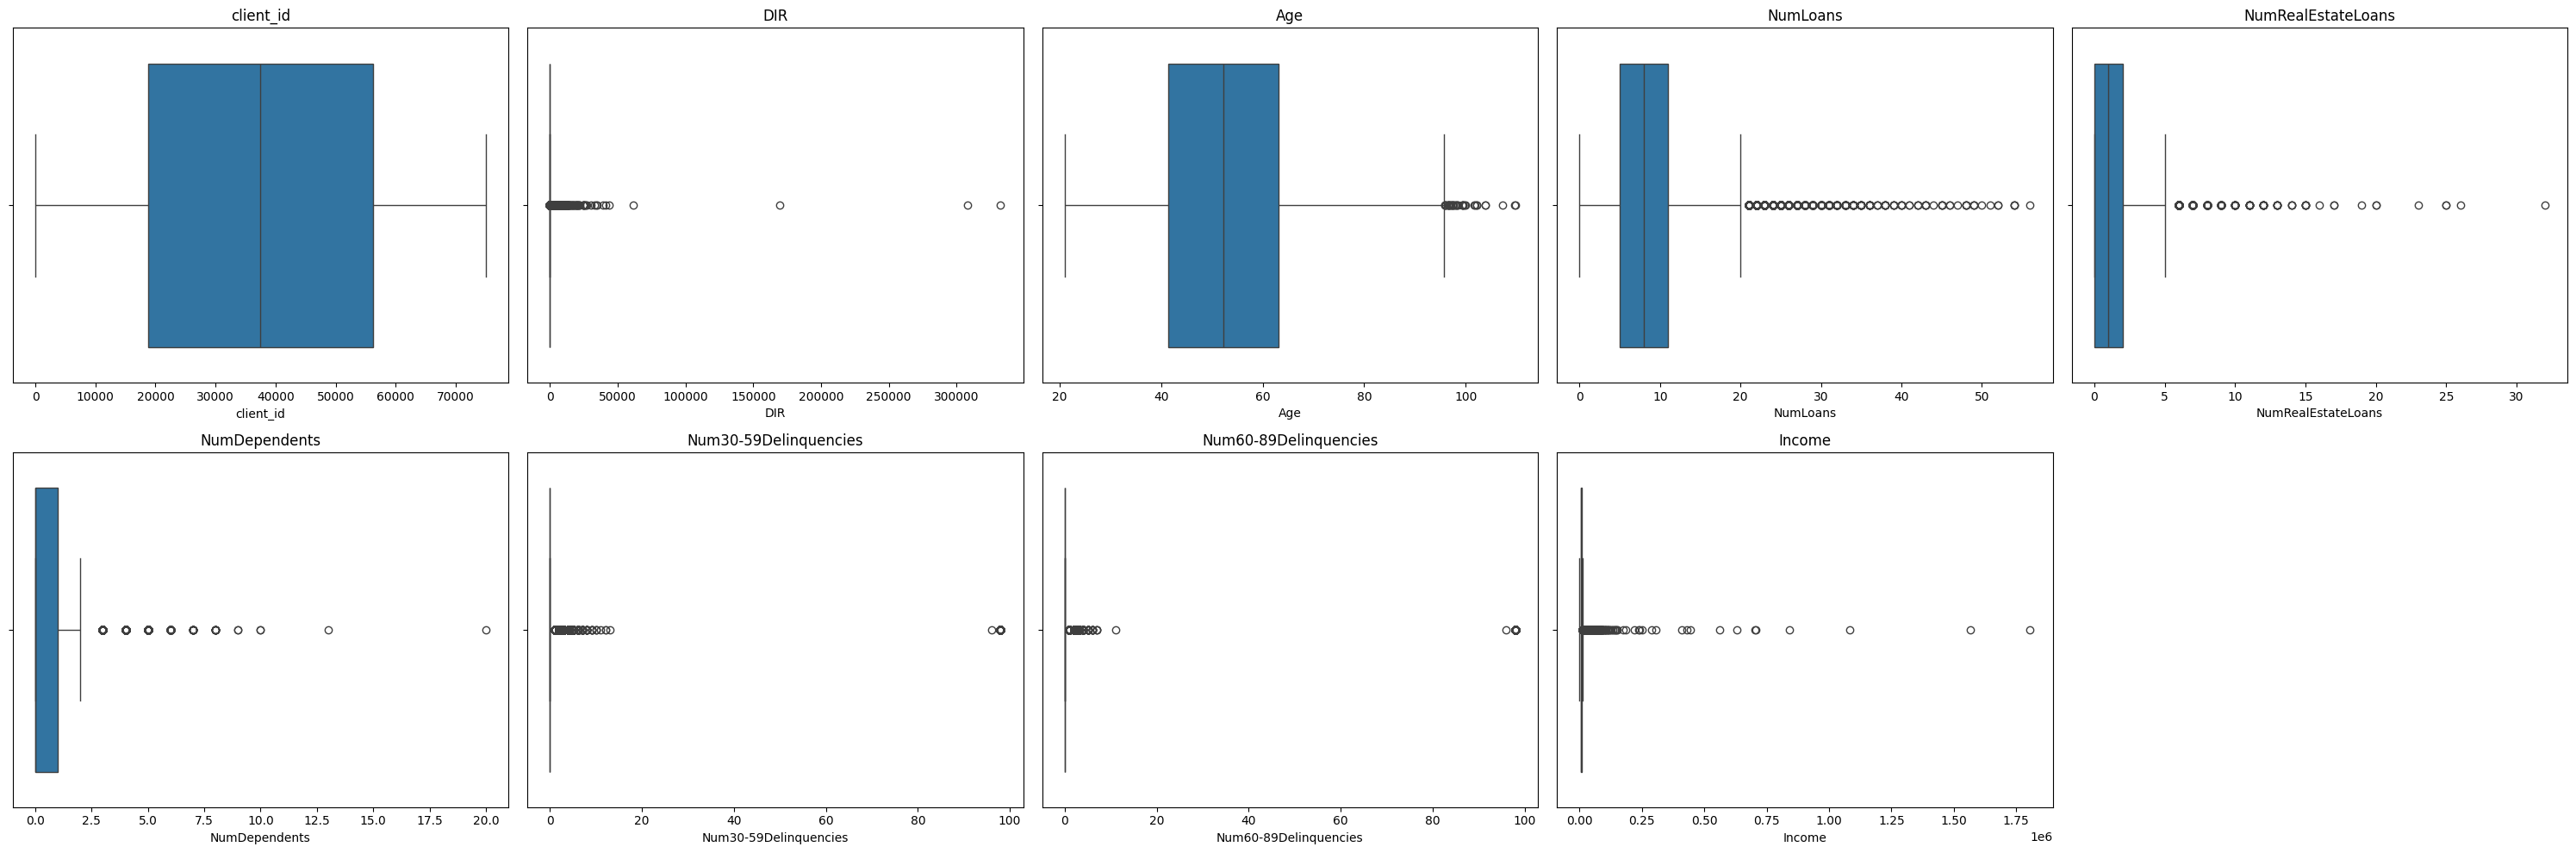

In [9]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(2, 5, figsize=(30, 10))

for col, ax in zip(numeric_columns, axes.flatten()):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)

axes[1][4].remove()
plt.tight_layout()

Количество выбросов по признакам

In [10]:
outliers = {}

for column in numeric_columns:
    Q1 = df[column].quantile(.25)
    Q3 = df[column].quantile(.75)
    IQR = Q3 - Q1

    # добавим "усы"
    left_whisker = Q1 - 1.5 * IQR
    right_whisker = Q3 + 1.5 * IQR

    outlier = ((df[column] <= left_whisker) | (df[column] >= right_whisker)).sum()
    outliers[column] = outlier

print('Выбросы')
for key in outliers.keys():
    print(f'{key}: {outliers[key]}')

Выбросы
client_id: 0
DIR: 15608
Age: 36
NumLoans: 2606
NumRealEstateLoans: 744
NumDependents: 6518
Num30-59Delinquencies: 75000
Num60-89Delinquencies: 75000
Income: 4781
BalanceToCreditLimit: 398
Delinquent90: 75000


Удаляем выбросы

In [11]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(.25)
    Q3 = df[column].quantile(.75)
    IQR = Q3 - Q1

    left_whisker = Q1 - 1.5 * IQR
    right_whisker = Q3 + 1.5 * IQR

    filter = (df[column] >= left_whisker) & (df[column] <= right_whisker) | df[column].isna()
    return df[filter]


df = remove_outliers(df, col)
df.head()

,client_id,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
0,0,0.496289,49.1,13,0,0.000000,2,0,5298.360639,0.387028,0
1,1,0.433567,48.0,9,2,2.000000,1,0,6008.056256,0.234679,0
2,2,2206.731199,55.5,21,1,0.755966,1,0,6740.059287,0.348227,0
3,3,886.132793,55.3,3,0,0.000000,0,0,6740.059287,0.971930,0
4,4,0.000000,52.3,1,0,0.000000,0,0,2504.613105,1.004350,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74602 entries, 0 to 74999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              74602 non-null  int64  
 1   DIR                    74602 non-null  float64
 2   Age                    74602 non-null  float64
 3   NumLoans               74602 non-null  int64  
 4   NumRealEstateLoans     74602 non-null  int64  
 5   NumDependents          74602 non-null  float64
 6   Num30-59Delinquencies  74602 non-null  int64  
 7   Num60-89Delinquencies  74602 non-null  int64  
 8   Income                 74602 non-null  float64
 9   BalanceToCreditLimit   74602 non-null  float64
 10  Delinquent90           74602 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 6.8 MB


In [13]:
df.isnull().sum()

client_id                0
DIR                      0
Age                      0
NumLoans                 0
NumRealEstateLoans       0
NumDependents            0
Num30-59Delinquencies    0
Num60-89Delinquencies    0
Income                   0
BalanceToCreditLimit     0
Delinquent90             0
dtype: int64

# Подготовка данных для обучения

In [14]:
X = df.drop('Delinquent90', axis=1)
y = df['Delinquent90']
display(X.head())
display(y.head())

,client_id,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit
0,0,0.496289,49.1,13,0,0.000000,2,0,5298.360639,0.387028
1,1,0.433567,48.0,9,2,2.000000,1,0,6008.056256,0.234679
2,2,2206.731199,55.5,21,1,0.755966,1,0,6740.059287,0.348227
3,3,886.132793,55.3,3,0,0.000000,0,0,6740.059287,0.971930
4,4,0.000000,52.3,1,0,0.000000,0,0,2504.613105,1.004350


0    0
1    0
2    0
3    0
4    0
Name: Delinquent90, dtype: int64

Скалирование данных

In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [16]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

Добавляем веса классов

In [17]:
class_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y= y_train)

# Дерево решений

In [18]:
model_tree = DecisionTreeClassifier(max_depth=1)
model_tree.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_tree.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ac}")

Accuracy: 0.7494009818870327


In [19]:
model_tree = DecisionTreeClassifier(max_depth=2)
model_tree.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_tree.predict(X_test)

ac = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ac}")

Accuracy: 0.7381076054355658


In [20]:
model_tree = DecisionTreeClassifier(max_depth=3)
model_tree.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_tree.predict(X_test)

ac = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ac}")

Accuracy: 0.7264623582044537


In [21]:
model_tree = DecisionTreeClassifier(max_depth=4)
model_tree.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_tree.predict(X_test)

ac = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ac}")

Accuracy: 0.7698597543606843


In [22]:
model_tree = DecisionTreeClassifier(max_depth=5)
model_tree.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_tree.predict(X_test)

ac = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ac}")

Accuracy: 0.772272582563965


In [23]:
model_tree = DecisionTreeClassifier(max_depth=6)
model_tree.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_tree.predict(X_test)

ac = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ac}")

Accuracy: 0.7536066754913624


In [24]:
model_tree = DecisionTreeClassifier(max_depth=7)
model_tree.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_tree.predict(X_test)

ac = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ac}")

Accuracy: 0.7704462056600928


In [25]:
model_tree = DecisionTreeClassifier(max_depth=8)
model_tree.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_tree.predict(X_test)

ac = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ac}")

Accuracy: 0.7529029339320722


In [26]:
model_tree = DecisionTreeClassifier(max_depth=9)
model_tree.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_tree.predict(X_test)

ac = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ac}")

Accuracy: 0.7609624503610865


In [27]:
model_tree = DecisionTreeClassifier(max_depth=10)
model_tree.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_tree.predict(X_test)

ac = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ac}")

Accuracy: 0.7783214088235787


In [28]:
model_tree = DecisionTreeClassifier(criterion= 'gini', splitter= 'best', max_depth=11, min_samples_leaf=1, min_samples_split=2)
model_tree.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_tree.predict(X_test)

ac = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ac}")

Accuracy: 0.7934183408454952


[Text(0.5771234958251473, 0.9583333333333334, 'x[9] <= 0.485\ngini = 0.5\nsamples = 14921\nvalue = [7460.5, 7460.5]'),
 Text(0.3574410609037328, 0.875, 'x[7] <= 0.06\ngini = 0.407\nsamples = 10721\nvalue = [5595.106, 2225.943]'),
 Text(0.46728227836444003, 0.9166666666666667, 'True  '),
 Text(0.26571709233791746, 0.7916666666666666, 'x[6] <= 0.017\ngini = 0.368\nsamples = 10454\nvalue = [5486.547, 1759.213]'),
 Text(0.14955795677799608, 0.7083333333333334, 'x[9] <= -0.386\ngini = 0.319\nsamples = 9457\nvalue = [4989.431, 1242.22]'),
 Text(0.09571463654223969, 0.625, 'x[4] <= 3.097\ngini = 0.258\nsamples = 7164\nvalue = [3799.04, 682.144]'),
 Text(0.0637278978388998, 0.5416666666666666, 'x[2] <= 0.482\ngini = 0.24\nsamples = 7103\nvalue = [3771.632, 610.339]'),
 Text(0.02848722986247544, 0.4583333333333333, 'x[0] <= -1.479\ngini = 0.299\nsamples = 4006\nvalue = [2117.445, 473.91]'),
 Text(0.010805500982318271, 0.375, 'x[1] <= -0.166\ngini = 0.459\nsamples = 275\nvalue = [141.88, 78.985]

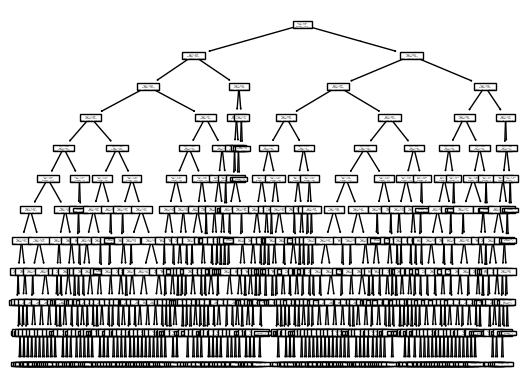

In [29]:
tree.plot_tree(model_tree)

# GridSearchCV

In [30]:
parameters = {
    'max_depth': range(1, 11),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20)
    }
clf = GridSearchCV(model_tree, parameters)
clf.fit(X_train, y_train)


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=DecisionTreeClassifier(max_depth=11),
             param_grid={'max_depth': range(1, 11),
                         'min_samples_leaf': range(1, 20),
                         'min_samples_split': range(2, 20)})

In [31]:
clf.best_score_

0.9309028385897313

# Ансамблевые методы

## KNeighborsClassifier

In [34]:
neib_model = KNeighborsClassifier(n_neighbors=5)
neib_model.fit(X_train, y_train)

KNeighborsClassifier()

### BaggingClassifier

In [45]:
bagging_parameters = {
    'n_estimators': [10, 20, 30],
    'max_samples': [0.8, 1.0],
    'bootstrap': [True, False]
}

bag_model = BaggingClassifier(estimator=neib_model, random_state=42)
grid_search = GridSearchCV(bag_model, bagging_parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=BaggingClassifier(estimator=KNeighborsClassifier(),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_samples': [0.8, 1.0],
                         'n_estimators': [10, 20, 30]},
             verbose=1)

In [46]:
grid_search.best_params_

{'bootstrap': True, 'max_samples': 0.8, 'n_estimators': 10}

### StackingClassifier

In [42]:
# Создаем базовые модели
base_models = [
    ('lr', LogisticRegression(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier())
]

# Создаем стекинг-модель
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Определяем параметры для поиска
param_grid = {
    'lr__C': [0.1, 1.0, 10.0],
    'dt__max_depth': [3, 5, 7],
    'knn__n_neighbors': [3, 5, 7],
    'final_estimator__C': [0.1, 1.0, 10.0]
}

# Создаем GridSearchCV для поиска оптимальных параметров
grid_search = GridSearchCV(stacking_model, param_grid, cv=5, n_jobs=-1, verbose=2)

# Обучаем модель
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Оцениваем модель на тестовых данных
print("Точность на тестовых данных:", grid_search.score(X_test, y_test))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Лучшие параметры: {'dt__max_depth': 3, 'final_estimator__C': 10.0, 'knn__n_neighbors': 3, 'lr__C': 1.0}
Точность на тестовых данных: 0.9348201270085957


### RandomForestClassifier

In [49]:
# Создаем модель случайного леса
rf_model = RandomForestClassifier(random_state=42)

# Определяем параметры для поиска
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 7],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Создаем GridSearchCV для поиска оптимальных параметров
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1, verbose=2)

# Обучаем модель
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Оцениваем модель на тестовых данных
print("Точность на тестовых данных:", grid_search.score(X_test, y_test))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", 

Лучшие параметры: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
Точность на тестовых данных: 0.9367637941723497


### XGBoost

In [59]:
model_xgb = XGBClassifier(booster='gbtree', n_estimators = 450, learning_rate = 0.7, random_state = 150)
model_xgb.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_xgb.predict(X_test)

fs = f1_score(y_test, y_pred, average='weighted')
print(f"F-score: {fs}")

importance = model_xgb.feature_importances_
print('Важность признаков:', importance)


F-score: 0.9133555373368517
Важность признаков: [0.04641302 0.04479553 0.04860354 0.0423632  0.07582387 0.04268209
 0.2057788  0.3319526  0.05104042 0.11054696]
